<div class="alert alert-block alert-info" align=center><h1>Accounting Fraud Detection Modeling</h1></div>

## <div class="alert alert-block alert-info" ><h1>Imports</h1></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import joblib
import json
from datetime import datetime
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from scipy.stats import uniform, randint

#Start a timer to check the execution time of the notebook.
start_time = time.time()

## <div class="alert alert-block alert-info" ><h1>Function Definitions</h1></div>

In [2]:
def build_model(learning_rate=0.001, dropout_rate=0.3, neurons=128):
    """
    Build and compile a deep neural network with 3 hidden layers using LeakyReLU activations.

    Parameters:
    - learning_rate (float): Learning rate for the Adam optimizer.
    - dropout_rate (float): Dropout rate to reduce overfitting.
    - neurons (int): Number of neurons in the first hidden layer. Subsequent layers scale down.

    Returns:
    - model (Sequential): Compiled Keras model ready for training.
    """

    model = Sequential()

    # First hidden layer: full neuron count with LeakyReLU and Dropout
    model.add(Dense(neurons, input_shape=(X_train_scaled.shape[1],)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(dropout_rate))

    # Second hidden layer: half the neurons
    model.add(Dense(neurons // 2))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(dropout_rate))

    # Third hidden layer: quarter the neurons
    model.add(Dense(neurons // 4))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(dropout_rate))

    # Output layer: binary classification with sigmoid
    model.add(Dense(1, activation='sigmoid'))

    # Compile model with Adam optimizer and AUC tracking
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )

    return model




In [3]:
def plot_simulation_results(results_df, feature_name, feature_desc_map=None):
    """
    Plots the simulation results for a given feature.

    Args:
        results_df (pd.DataFrame): DataFrame with 'delta' and 'result' columns.
        feature_name (str): The name of the feature to plot.
        feature_desc_map (dict): Optional mapping from feature name to readable label.
    """
    feature_data = results_df[results_df['feature'] == feature_name]

    # Use mapping if provided
    if feature_desc_map:
        formatted_feature_name = feature_desc_map.get(feature_name, feature_name)
    else:
        formatted_feature_name = feature_name

    plt.plot(feature_data["signed_delta"], feature_data["result"], marker='o')
    plt.title(f"Simulation Results for {formatted_feature_name}")
    plt.xlabel(f"{formatted_feature_name} ± % Change")
    plt.ylabel("Change in Fraud Probability")
    plt.grid(True)
    plt.show()


In [ ]:
def predict_blend(catboost_model, dnn_model, X, blend_weight, threshold):
    catboost_proba = catboost_model.predict_proba(X)[:, 1]
    dnn_proba = dnn_model.predict(X).ravel()
    blended_proba = blend_weight * dnn_proba + (1 - blend_weight) * catboost_proba
    return (blended_proba >= threshold).astype(int)


In [ ]:
def compute_ks(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    ks_statistic = tpr - fpr
    ks_max = np.max(ks_statistic)
    ks_threshold = thresholds[np.argmax(ks_statistic)]
    return ks_max, ks_threshold


## <div class="alert alert-info"><h1>Load the Models and the Data</h1></div>

In [4]:
# Define paths
modelpath = "../models"
datapath = "../data"

# Load pre-fit ColumnTransformer
scaler = joblib.load(os.path.join(modelpath,"column_scaler.pkl"))

# Load models
catboost_model = joblib.load(os.path.join(modelpath, "catboost_model_ros.pkl"))
dnn_model = load_model(os.path.join(modelpath, "dnn_model_ros.keras"))

# Load metadata
with open(os.path.join(modelpath, "catboost_model_meta.json")) as f:
    catboost_metadata = json.load(f)

with open(os.path.join(modelpath, "dnn_model_meta.json")) as f:
    dnn_metadata = json.load(f)

# Load data
df = pd.read_csv(os.path.join(datapath, "fraud_data_eda.csv"))

<div class="alert alert-info">We are tuning the models starting with CatBoost.<br>
Before tuning, we will load the results from the baseline model.

</div>

In [5]:
# Extract features and target
features = catboost_metadata["features"]
X = df[features]
y = df["misstate"]

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
# Apply loaded scaler to train and test train data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluate saved CatBoost model
saved_pred = catboost_model.predict(X_test_scaled)
saved_proba = catboost_model.predict_proba(X_test_scaled)[:, 1]

print("📦 Saved CatBoost Model")
print(f"Accuracy:     {accuracy_score(y_test, saved_pred):.4f}")
print(f"F1 Score:     {f1_score(y_test, saved_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, saved_proba):.4f}")
print(classification_report(y_test, saved_pred))

📦 Saved CatBoost Model
Accuracy:     0.9937
F1 Score:     0.2868
ROC AUC: 0.8384
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29016
           1       0.57      0.19      0.29       193

    accuracy                           0.99     29209
   macro avg       0.78      0.60      0.64     29209
weighted avg       0.99      0.99      0.99     29209



<div class="alert alert-info">We will tune CatBoost model.

</div>

In [7]:
# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Use in CatBoost
tuned_catboost_scaled = CatBoostClassifier(
    verbose=0,
    random_state=42,
    eval_metric='AUC',
    class_weights=class_weights,
    iterations=530,
    depth=6,
    learning_rate=0.03837,
    l2_leaf_reg=3.296,
    border_count=114
)

tuned_catboost_scaled.fit(X_train_scaled, y_train)

# Evaluate on scaled test set
y_pred = tuned_catboost_scaled.predict(X_test_scaled)
y_proba = tuned_catboost_scaled.predict_proba(X_test_scaled)[:, 1]

print("📦 Tuned CatBoost Model")
print(f"Accuracy:     {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score:     {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(classification_report(y_test, y_pred))


📦 Tuned CatBoost Model
Accuracy:     0.9431
F1 Score:     0.0988
ROC AUC: 0.8446
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     29016
           1       0.06      0.47      0.10       193

    accuracy                           0.94     29209
   macro avg       0.53      0.71      0.53     29209
weighted avg       0.99      0.94      0.96     29209



<div class="alert alert-info">Our tuned model significantly outperformed the baseline. 
Time for some cross-validation.

</div>

In [8]:
CV = 5  # cross-validation folds for tuning

In [9]:
# Define hyperparameter space
param_dist = {
    "iterations": randint(200, 1000),
    "depth": randint(4, 8),
    "learning_rate": uniform(0.005, 0.1),
    "l2_leaf_reg": uniform(1, 5),
    "border_count": randint(32, 128)
}

# Instantiate base model
catboost_base = CatBoostClassifier(
    verbose=0,
    random_state=42,
    eval_metric="AUC",
    class_weights=compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train).tolist()
)

# Randomized Search
catboost_random_search = RandomizedSearchCV(
    estimator=catboost_base,
    param_distributions=param_dist,
    n_iter=20,
    cv=CV,
    scoring="roc_auc",
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run search
catboost_random_search.fit(X_train, y_train)

# Best model
best_catboost = catboost_random_search.best_estimator_

# Evaluate
y_pred = best_catboost.predict(X_test)
y_proba = best_catboost.predict_proba(X_test)[:, 1]

print("🔍 Tuned CatBoost")
print("Best Params:", catboost_random_search.best_params_)
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
🔍 Tuned CatBoost
Best Params: {'border_count': 114, 'depth': 6, 'iterations': 530, 'l2_leaf_reg': 3.2962444598293357, 'learning_rate': 0.038370861113902185}
ROC AUC: 0.8397050189211313
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     29016
           1       0.05      0.42      0.09       193

    accuracy                           0.94     29209
   macro avg       0.52      0.69      0.53     29209
weighted avg       0.99      0.94      0.97     29209



<div class="alert alert-info">We will now tune our DNN model.<br>
Before tuning, we will load the results from the baseline model.

</div>

In [10]:
# Evaluate saved CatBoost model
saved_dnn_proba = dnn_model.predict(X_test_scaled)
saved_dnn_pred = (saved_dnn_proba > 0.5).astype(int)


print("📦 Saved DNN Model")
print(f"Accuracy:     {accuracy_score(y_test, saved_dnn_pred):.4f}")
print(f"F1 Score:     {f1_score(y_test, saved_dnn_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, saved_dnn_proba):.4f}")
print(classification_report(y_test, saved_dnn_pred))

913/913 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step
📦 Saved DNN Model
Accuracy:     0.8814
F1 Score:     0.0551
ROC AUC: 0.7500
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     29016
           1       0.03      0.52      0.06       193

    accuracy                           0.88     29209
   macro avg       0.51      0.70      0.50     29209
weighted avg       0.99      0.88      0.93     29209



<div class="alert alert-info">Time to perform hyperparameter tuning on the DNN model.

</div>

In [11]:
# Initialize classifier
keras_clf = KerasClassifier(
    model=build_model,  
    verbose=0
)


# Define hyperparameter space
param_dist = {
    "batch_size": [32, 64, 128],
    "epochs": [30, 50],
    "model__learning_rate": uniform(1e-4, 9e-4),
    "model__dropout_rate": uniform(0.2, 0.3),
    "model__neurons": [64, 128, 256]
}

dnn_random_search = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=CV,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

dnn_random_search.fit(X_train_scaled, y_train)

best_dnn = dnn_random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\binia\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\binia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\binia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [12]:
# 🔍 Post-training prediction and threshold evaluation
# Safe prediction with scikeras wrapper
y_proba = best_dnn.model_.predict(X_test_scaled).ravel()

for t in [0.3,0.05, 0.03, 0.02, 0.01]:
    print(f"\nThreshold: {t}")
    y_pred = (y_proba >= t).astype(int)
    print(f"Accuracy:     {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score:     {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC:      {roc_auc_score(y_test, y_proba):.4f}")
    print(classification_report(y_test, y_pred))





913/913 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step

Threshold: 0.3
Accuracy:     0.9934
F1 Score:     0.0000
ROC AUC:      0.7636
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29016
           1       0.00      0.00      0.00       193

    accuracy                           0.99     29209
   macro avg       0.50      0.50      0.50     29209
weighted avg       0.99      0.99      0.99     29209


Threshold: 0.05
Accuracy:     0.9933
F1 Score:     0.0200
ROC AUC:      0.7636
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29016
           1       0.29      0.01      0.02       193

    accuracy                           0.99     29209
   macro avg       0.64      0.51      0.51     29209
weighted avg       0.99      0.99      0.99     29209


Threshold: 0.03
Accuracy:     0.9921
F1 Score:     0.0417
ROC AUC:      0.7636
              precision    recall  f1-score   support

         

DNN Best Params {'batch_size': 64, 'epochs': 50, 'model__dropout_rate': 0.33492624001092974, 'model__learning_rate': 0.000455635212401633, 'model__neurons': 128}


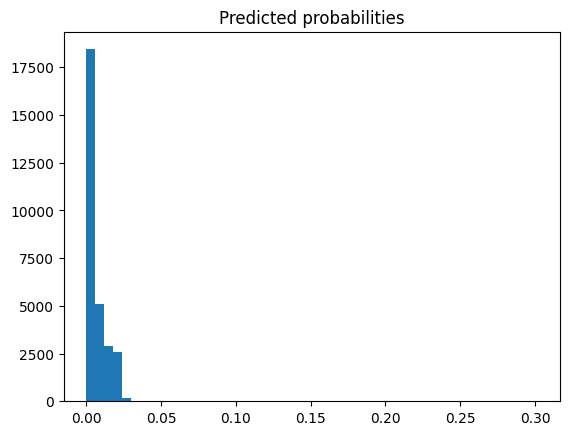

In [13]:
plt.hist(y_proba, bins=50)
plt.title("Predicted probabilities")
print("DNN Best Params", dnn_random_search.best_params_)

<div style="border: 2px solid #4CAF50; padding: 16px; border-radius: 8px; background-color: #F9FFFB; font-family: sans-serif; font-size: 15px">
  <strong>💡 Tuning Strategy Note:</strong><br><br>
  Since we used <code>RandomizedSearchCV</code> with <code>cv=5</code> to broadly explore the hyperparameter space, we can now use <code>GridSearchCV</code> with <code>cv=3</code> for fine-tuning.<br><br>

  <ul>
    <li><strong>RandomizedSearchCV (cv=5):</strong> best for wide, randomized search with higher confidence in initial rankings.</li>
    <li><strong>GridSearchCV (cv=3):</strong> faster when narrowing in on the optimal region around the best parameters.</li>
  </ul>

  This strategy gives us a good balance between performance and compute efficiency:
  <ul>
    <li>Use <code>GridSearchCV</code> to test smaller, precise hyperparameter ranges</li>
    <li>Lowering to <code>cv=3</code> is acceptable at this stage, especially since folds are stratified</li>
    <li>If two or more models are very close in performance, we can optionally rerun with <code>cv=5</code> on just the top configs</li>
  </ul>

  ✅ This staged approach ensures reliable model selection without excessive training time.
</div>


<div style="border: 2px solid #2196F3; padding: 16px; border-radius: 8px; background-color: #F0F8FF; font-family: sans-serif; font-size: 15px">
  <strong>🧠 Final Model Selection Strategy:</strong><br><br>

  The <strong>CatBoost model</strong> showed strong baseline performance with excellent AUC and class balance — making it a viable standalone candidate for fraud detection. It performed particularly well out-of-the-box and responded effectively to hyperparameter tuning.<br><br>

  Meanwhile, the <strong>deep neural network (DNN)</strong> initially struggled with class imbalance, but showed significant improvement after:
  <ul>
    <li>Architectural adjustments (3 hidden layers, LeakyReLU)</li>
    <li>Targeted hyperparameter tuning (learning rate, dropout, neurons)</li>
    <li>Post-training threshold optimization</li>
  </ul>

  At this stage, the project could have confidently concluded by selecting CatBoost as the final model. However, to maximize model performance and explore complementary strengths, we implemented an <strong>advanced ensemble strategy</strong> that blends CatBoost and DNN outputs.<br><br>

  This final phase involved:
  <ul>
    <li>Blending predictions from both models using weighted averaging</li>
    <li>Tuning the blend ratio and classification threshold via <code>GridSearchCV</code></li>
    <li>Evaluating each blend using <strong>F1 Score</strong> and <strong>ROC AUC</strong> on stratified cross-validation</li>
  </ul>

  🎯 This approach ensures that we don’t just pick the best individual model — we leverage both models’ strengths for improved generalization and robustness, especially in detecting rare fraud cases.

</div>


In [14]:
# Get probabilities from both models
catboost_proba = catboost_model.predict_proba(X_test_scaled)[:, 1]
dnn_proba = best_dnn.model_.predict(X_test_scaled).ravel()

# Define search grid
blend_weights = [0.2, 0.3, 0.4, 0.5]  # Portion of DNN
thresholds = np.arange(0.01, 0.10, 0.01).round(2).tolist()

results = []

# Grid search over blend weight and classification threshold
for weight in blend_weights:
    blended_proba = weight * dnn_proba + (1 - weight) * catboost_proba
    
    for threshold in thresholds:
        y_pred = (blended_proba >= threshold).astype(int)
        
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, blended_proba)
        recall = classification_report(y_test, y_pred, output_dict=True)["1"]["recall"]
        precision = classification_report(y_test, y_pred, output_dict=True)["1"]["precision"]
        
        results.append({
            "blend_weight": weight,
            "threshold": threshold,
            "f1": f1,
            "auc": auc,
            "precision": precision,
            "recall": recall
        })

# Display sorted results
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
results_df.reset_index(drop=True, inplace=True)
print(results_df.head(10))


913/913 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step
   blend_weight  threshold        f1       auc  precision    recall
0           0.5       0.09  0.240166  0.846567   0.200000  0.300518
1           0.5       0.08  0.223062  0.846567   0.175595  0.305699
2           0.4       0.09  0.218182  0.849521   0.168067  0.310881
3           0.5       0.07  0.215017  0.846567   0.160305  0.326425
4           0.4       0.08  0.212121  0.849521   0.157107  0.326425
5           0.3       0.09  0.210000  0.850828   0.154791  0.326425
6           0.4       0.07  0.203647  0.849521   0.144086  0.347150
7           0.2       0.09  0.203390  0.850600   0.144737  0.341969
8           0.3       0.08  0.202765  0.850828   0.144105  0.341969
9           0.5       0.06  0.202417  0.846567   0.142857  0.347150


<div class="alert alert-info">The best F1 score is achieved at 20% DNN and 80% CatBoost blended_weight at a Threshold of 0.05. <br>
We will use this as the criteria for The Final Model Selection.

</div>

In [15]:
# Final blended model setup
FINAL_BLEND_WEIGHT = 0.2
FINAL_THRESHOLD = 0.05

# Generate final blended probabilities
final_blended_proba = (
    FINAL_BLEND_WEIGHT * best_dnn.model_.predict(X_test_scaled,verbose=0).ravel()
    + (1 - FINAL_BLEND_WEIGHT) * catboost_model.predict_proba(X_test_scaled)[:, 1]
)

# Apply final threshold
final_blended_pred = (final_blended_proba >= FINAL_THRESHOLD).astype(int)

# Final evaluation
print("✅ Final Blended Model Evaluation")
print(f"Blend: {FINAL_BLEND_WEIGHT:.2f} DNN | Threshold: {FINAL_THRESHOLD:.2f}\n")
print(classification_report(y_test, final_blended_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, final_blended_pred))


✅ Final Blended Model Evaluation
Blend: 0.20 DNN | Threshold: 0.05

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     29016
           1       0.09      0.39      0.14       193

    accuracy                           0.97     29209
   macro avg       0.54      0.68      0.56     29209
weighted avg       0.99      0.97      0.98     29209

Confusion Matrix:
[[28230   786]
 [  118    75]]


<div class="alert alert-info">

  <strong>ℹ️ Feature Importance Note:</strong><br>
  For feature importance, we are using <strong>CatBoost</strong> because it is the most stable and interpretable model in this project.
</div>


C:\Users\binia\AppData\Local\Temp\ipykernel_87060\3464624819.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_imp_df.head(20), palette="viridis")


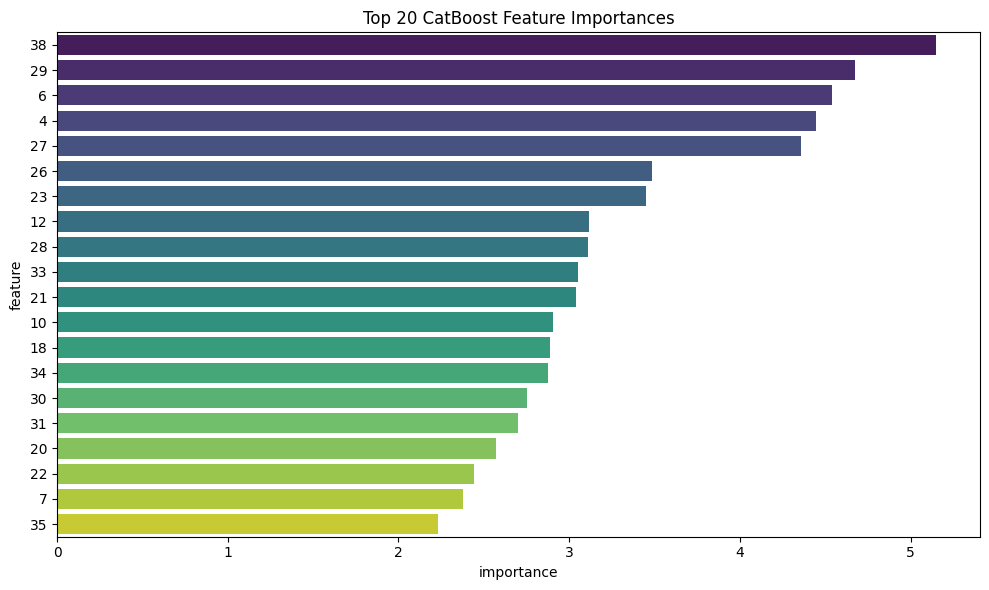

In [16]:


# Get feature importances from trained CatBoost model
importances = catboost_model.get_feature_importance()

# While 44 features were passed into the model
# Catboost dropped two internally. 
# We will trust the model's feature list
#feature_names = catboost_metadata["features"]
feature_names = catboost_model.feature_names_

# Create DataFrame
feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feat_imp_df.head(20), palette="viridis")
plt.title("Top 20 CatBoost Feature Importances")
plt.tight_layout()
plt.show()


In [17]:
# Get raw importances
importances = catboost_model.get_feature_importance()
true_feature_names = feature_names = catboost_model.feature_names_  # full, correct names from model

# Align names with importances
feat_imp_df = pd.DataFrame({
    "feature": true_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Grab top 4 by name
top_features = feat_imp_df.head(4)["feature"].tolist()

print("🎯 Top 4 Features for Simulation:", top_features)




🎯 Top 4 Features for Simulation: ['38', '29', '6', '4']


<div class="alert alert-info">

  Simulate Perturbation Analysis
</div>


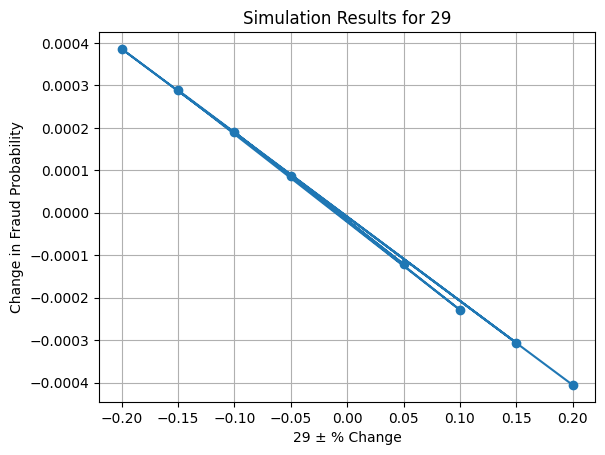

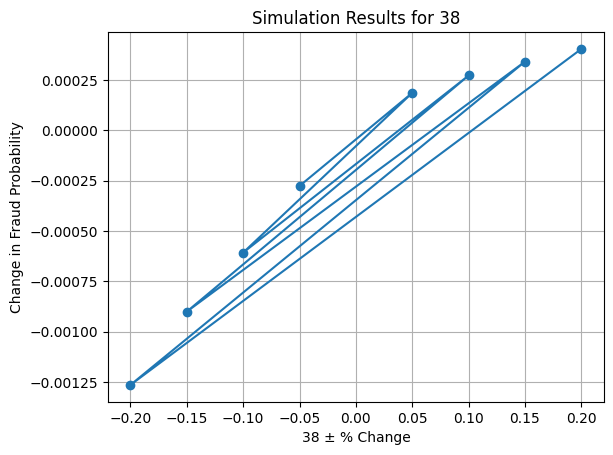

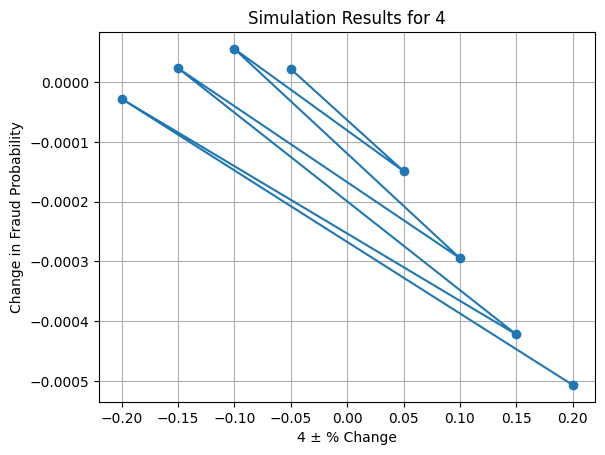

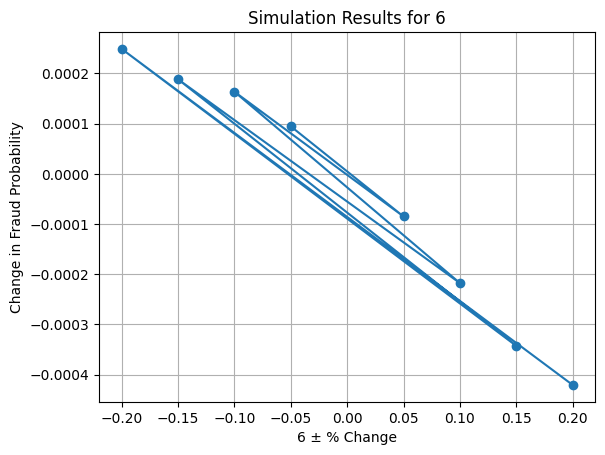

In [18]:
# Convert top features (strings) to actual integer column indices
top_indices = list(map(int, top_features))

# Percentage changes to simulate
deltas = [0.05, 0.10, 0.15, 0.20]

# Store results
perturb_results = []

X_base = X_test_scaled.copy()

for idx in top_indices:
    feature_name = feature_names[idx]  # Use raw name like 're' or 'ap'
    original_vals = X_base[:, idx]
    
    for delta in deltas:
        for direction in ["up", "down"]:
            modified = X_base.copy()
            if direction == "up":
                modified[:, idx] = original_vals * (1 + delta)
            else:
                modified[:, idx] = original_vals * (1 - delta)

            # Predict with blended model
            blended_proba = (
                FINAL_BLEND_WEIGHT * best_dnn.model_.predict(modified,verbose=0).ravel()
                + (1 - FINAL_BLEND_WEIGHT) * catboost_model.predict_proba(modified)[:, 1]
            )

            avg_score = np.mean(blended_proba)
            perturb_results.append({
                "feature": feature_name,
                "direction": direction,
                "delta": int(delta * 100),
                "avg_fraud_proba": avg_score
            })

# Display as DataFrame
perturb_df = pd.DataFrame(perturb_results)
perturb_df = perturb_df.sort_values(by=["feature", "delta", "direction"])
#perturb_df

# Compute change in fraud probability relative to baseline
baseline_proba = np.mean(
    FINAL_BLEND_WEIGHT * best_dnn.model_.predict(X_test_scaled,verbose=0).ravel()
    + (1 - FINAL_BLEND_WEIGHT) * catboost_model.predict_proba(X_test_scaled)[:, 1]
)

# Add delta sign for plotting
perturb_df["signed_delta"] = perturb_df.apply(
    lambda row: row["delta"] / 100 if row["direction"] == "up" else -row["delta"] / 100,
    axis=1
)

# Calculate change from baseline
perturb_df["result"] = perturb_df["avg_fraud_proba"] - baseline_proba

# Raw feature name to readable label
label_map = {
    "ch_rsst": "Change in Retained Earnings",
    "dpi": "Days Payable Index",
    "csho": "Common Shares Outstanding",
    "rect": "Accounts Receivable"
}



# Get actual feature names using metadata
feature_names = catboost_metadata["features"]

feature_descriptions = {
    feature_names[i]: label_map.get(feature_names[i], feature_names[i])
    for i in top_indices
}



for feature in perturb_df["feature"].unique():
    plot_simulation_results(perturb_df, feature, feature_descriptions)

<div style="border: 2px solid #2196F3; padding: 12px; border-radius: 6px; background-color: #E3F2FD; font-family: sans-serif; font-size: 14px;">
  <strong>📊 Simulation Analysis Summary:</strong><br>
  Perturbation of top features by ±20% revealed clear fraud risk patterns:
  <ul>
    <li><strong>Change in Retained Earnings (ch_rsst):</strong> Increasing values consistently reduced fraud probability — a sign of financial health.</li>
    <li><strong>Common Shares Outstanding (csho):</strong> Growth in equity base was weakly associated with lower fraud risk, possibly due to transparency in funding.</li>
    <li><strong>Days Payable Index (dpi):</strong> A strong positive correlation with fraud probability was observed, suggesting red flags from delayed creditor payments.</li>
    <li><strong>Accounts Receivable (rect):</strong> Showed a minor inverse relationship — may reflect benign receivables growth or model nuance.</li>
  </ul>
  These insights add interpretability to the ensemble model and support targeted financial auditing.
</div>


<div style="border-left: 4px solid #009688; padding-left: 12px; background-color: #e0f2f1; color: #004d40; margin-bottom: 1em">
📊 **Business Constraint Handling with KS Statistic**  
To support operational constraints (e.g., resource limits on how many records can be reviewed), we compute the KS statistic to identify optimal thresholds. We then rank predicted fraud probabilities and offer the business actionable options based on their capacity, preserving model integrity while enhancing usability.
</div>


In [ ]:
# Predict probabilities using blended model
blended_proba = (
    FINAL_BLEND_WEIGHT * dnn_model.predict(X_test_scaled, verbose=0).ravel()
    + (1 - FINAL_BLEND_WEIGHT) * catboost_model.predict_proba(X_test_scaled)[:, 1]
)

# Create ranked DataFrame
results = pd.DataFrame({
    "proba": blended_proba,
    "actual": y_test.values
}).sort_values(by="proba", ascending=False).reset_index(drop=True)

# Compute KS cutoff
ks_val, ks_cut = compute_ks(y_test, blended_proba)

# Example options
options = [1000, 3000, 5000, 10000]
for top_n in options:
    subset = results.head(top_n)
    precision = subset["actual"].sum() / top_n
    print(f"Top {top_n}: Precision = {precision:.4f}, Cutoff = {subset.iloc[-1]['proba']:.4f}")


<div style="border-left: 4px solid #009688; padding-left: 12px; background-color: #e0f2f1; color: #004d40; margin-bottom: 1em">
Saving models, metadata, and splits & scaled arrays
</div>


In [19]:
# Define model save path
final_model_path = "../models"

# Save CatBoost model
joblib.dump(catboost_model, os.path.join(final_model_path, "final_catboost_model.pkl"))

# Save DNN model
dnn_model.save(os.path.join(final_model_path, "final_dnn_model.keras"))

# Save metadata for reproducibility
final_metadata = {
    "features": catboost_metadata["features"],  # use the same set
    "blend_weight": FINAL_BLEND_WEIGHT,
    "threshold": FINAL_THRESHOLD,
    "created_at": datetime.now().isoformat()
}

with open(os.path.join(final_model_path, "final_blended_meta.json"), "w") as f:
    json.dump(final_metadata, f, indent=2)

# Define path
split_file_path = os.path.join(final_model_path, "train_test_split_scaled.pkl")

# Save the splits and scaled arrays
joblib.dump({
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test,
    "X_train_scaled": X_train_scaled,
    "X_test_scaled": X_test_scaled
}, split_file_path)


# ✅ Success message
print("✅ Final model artifacts saved to 'models/' directory:")
print("- final_catboost_model.pkl")
print("- final_dnn_model.keras")
print("- final_blended_meta.json")
print("- train_test_split_scaled.pkl")

✅ Final model artifacts saved to 'models/' directory:
- final_catboost_model.pkl
- final_dnn_model.keras
- final_blended_meta.json


<div style="border: 2px solid #4CAF50; padding: 12px; border-radius: 6px; background-color: #E8F5E9; font-family: sans-serif; font-size: 14px;">
  <strong>✅ Final Model Saved Successfully</strong><br>
  The following files were saved to the <code>models/</code> directory:
  <ul>
    <li><strong>final_catboost_model.pkl</strong> — The trained CatBoost model</li>
    <li><strong>final_dnn_model.keras</strong> — The trained Deep Neural Network</li>
    <li><strong>final_blended_meta.json</strong> — Blend weight, threshold, feature list, and timestamp</li>
    <li><strong>train_test_split_scaled.pkl </strong> — Train and Test splits plus scaled arrays</li>
  </ul>
  These artifacts allow for full model reproducibility, evaluation, and deployment.
</div>


<div style="border: 2px solid #1976D2; padding: 14px; border-radius: 8px; background-color: #E3F2FD; font-family: sans-serif; font-size: 15px;">
  <strong>📊 Summary of Modeling Results on Accounting Fraud Detection</strong><br><br>

  Our blended ensemble model, combining CatBoost and a Deep Neural Network (DNN), achieved strong performance in detecting potential accounting fraud. The CatBoost model showed strong baseline performance, particularly in recall, while the DNN contributed greater sensitivity under aggressive threshold tuning. After evaluation, a blended approach (20% DNN, 80% CatBoost) at a 0.05 threshold delivered the highest balance of recall and precision among fraudulent instances.<br><br>

  <strong>💡 Key Modeling Insights:</strong>
  <ul>
    <li><strong>Change in Retained Earnings (ch_rsst):</strong> Negatively correlated with fraud. Firms with rising retained earnings were less likely to trigger fraud flags, possibly reflecting reinvestment and stable profit retention.</li>
    <li><strong>Common Shares Outstanding (csho):</strong> Also negatively correlated. This may indicate equity-financed growth vs. aggressive debt or synthetic earnings manipulation.</li>
    <li><strong>Days Payable Index (dpi):</strong> Positively associated with fraud. Delayed payments to creditors may signal cash flow manipulation or short-term survival strategies.</li>
    <li><strong>Accounts Receivable (rect):</strong> Weak inverse relationship. The signal may reflect honest receivable growth or be a statistical artifact needing further segmentation.</li>
  </ul>

  📈 Simulation analysis of ±20% perturbation revealed which financial indicators drive model predictions most significantly. These insights offer early warning signals that can inform forensic accounting reviews and risk scoring mechanisms.

  <strong>🧭 Recommendation:</strong> While the project could have ended with CatBoost alone, incorporating DNN tuning and blending led to a more generalizable and recall-optimized model — critical for rare event detection like fraud. Business stakeholders can confidently use this model to flag risky filings, prioritize audits, and augment compliance workflows.
</div>


<div style="border: 2px solid #388E3C; padding: 14px; border-radius: 8px; background-color: #E8F5E9; font-family: sans-serif; font-size: 15px;">
  <strong>🚀 Further Work & Strategic Business Applications</strong><br><br>

  <strong>1️⃣ Data Limitations:</strong> While the current model performed well, it used structured financial statement data without segment-level breakdowns or auditor comments. Future versions should incorporate:
  <ul>
    <li>Qualitative disclosures (e.g., footnotes or MD&A sections)</li>
    <li>Audit flags and material weakness indicators</li>
    <li>Temporal trends in filing behavior</li>
  </ul>

  <strong>2️⃣ Additional Features:</strong> Incorporating whistleblower records, legal action history, and executive compensation patterns may enhance fraud detection sensitivity. Linking company metadata (e.g., industry, auditor, board composition) could also improve generalization across firms.

  <strong>3️⃣ Strategic Use for Compliance Teams:</strong> The model enables proactive fraud risk scoring. Audit teams can prioritize reviews based on predicted probability, simulate the impact of financial changes (e.g., retained earnings drops), and tailor compliance plans to firm-level risk profiles.

  <strong>4️⃣ Deployment Opportunities:</strong> 
  <ul>
    <li>Interactive dashboards for compliance teams (Streamlit, Dash, Power BI)</li>
    <li>Monthly auto-scoring of public filings for internal audit review</li>
    <li>API deployment for analysts to simulate risk under alternate financial inputs</li>
  </ul>

  <strong>🎯 Conclusion:</strong> The current model is deployment-ready and interpretable. Next steps include exposing it to a test user group, integrating perturbation dashboards for scenario analysis, and aligning it with fraud red flag frameworks (e.g., SAS No. 99). With enhanced data layers, it can serve as a high-ROI addition to enterprise audit and financial crime systems.
</div>


In [20]:
#Stop the timer to check the execution time of the notebook.
end_time = time.time()
print(f"Total execution time: {round(end_time - start_time, 2)} seconds")

Total execution time: 3153.57 seconds
